# Converting Notebooks

## Recipe

1. Retrieve the notebook and it’s accompanying resources (you are responsible for this).

2. Feed the notebook into the Exporter, which:

    1. Sequentially feeds the notebook into an array of Preprocessors. Preprocessors only act on the structure of the notebook, and have unrestricted access to it.

    2. Feeds the notebook into the Jinja templating engine, which converts it to a particular format depending on which template is selected.

3. The exporter returns the converted notebook and other relevant resources as a tuple.

4. You write the data to the disk using the built-in FilesWriter (which writes the notebook and any extracted files to disk), or elsewhere using a custom Writer.

In [1]:
from urllib.request import urlopen

url = 'http://jakevdp.github.com/downloads/notebooks/XKCD_plots.ipynb'
response = urlopen(url).read().decode()
response[0:60] + ' ...'

'{\n "cells": [\n  {\n   "cell_type": "markdown",\n   "metadata": ...'

In [2]:
import nbformat
jake_notebook = nbformat.reads(response, as_version=4)
jake_notebook.cells[0]

{'cell_type': 'markdown',
 'metadata': {},
 'source': '# XKCD plots in Matplotlib'}

## HTML Exporter

In [9]:
from traitlets.config import Config

# 1. Import the exporter
from nbconvert import HTMLExporter

# 2. Instantiate the exporter. We use the `basic` template for now; we'll get into more details
# later about how to customize the exporter further.
html_exporter = HTMLExporter()
html_exporter.template_file = 'basic'

# 3. Process the notebook we loaded earlier
(body, resources) = html_exporter.from_notebook_node(jake_notebook)

In [10]:
print(body[:400] + '...')


<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div><div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<h1 id="XKCD-plots-in-Matplotlib">XKCD plots in Matplotlib<a class="anchor-link" href="#XKCD-plots-in-Matplotlib">&#182;</a></h1>
</div>
</div>
</div>
<div class="cell border-box-sizing text_cell rendered"><div class...


In [11]:
print("Resources:", resources.keys())
print("Metadata:", resources['metadata'].keys())
print("Inlining:", resources['inlining'].keys())
print("Extension:", resources['output_extension'])

Resources: dict_keys(['metadata', 'output_extension', 'inlining', 'raw_mimetypes', 'global_content_filter'])
Metadata: dict_keys(['name'])
Inlining: dict_keys(['css'])
Extension: .html


## RST Exporter

In [17]:
# Import the RST exproter
from nbconvert import RSTExporter
# Instantiate it
rst_exporter = RSTExporter()
# Convert the notebook to RST format
(body, resources) = rst_exporter.from_notebook_node(jake_notebook)

print(body[:970] + '...')
print('[.....]')
print(body[800:1200] + '...')


XKCD plots in Matplotlib

This notebook originally appeared as a blog post at `Pythonic
Perambulations <http://jakevdp.github.com/blog/2012/10/07/xkcd-style-plots-in-matplotlib/>`__
by Jake Vanderplas.

.. raw:: html

   <!-- PELICAN_BEGIN_SUMMARY -->

*Update: the matplotlib pull request has been merged! See* `This
post <http://jakevdp.github.io/blog/2013/07/10/XKCD-plots-in-matplotlib/>`__
*for a description of the XKCD functionality now built-in to
matplotlib!*

One of the problems I’ve had with typical matplotlib figures is that
everything in them is so precise, so perfect. For an example of what I
mean, take a look at this figure:

.. code:: ipython3

    from IPython.display import Image
    Image('http://jakevdp.github.com/figures/xkcd_version.png')




.. image:: output_3_0.png



Sometimes when showing schematic plots, this is the type of figure I
want to display. But drawing it by hand is a pain: I’d rather just use
matp...
[.....]
image:: output_3_0.png



Sometimes when sh

Notice that base64 images are not embedded, but instead there are filename-like strings, such as output_3_0.png. The strings actually are (configurable) keys that map to the binary data in the resources dict.  

Note, if you write an RST Plugin, you are responsible for writing all the files to the disk (or uploading, etc…) in the right location. Of course, the naming scheme is configurable.  

As an exercise, this notebook will show you how to get one of those images. First, take a look at the 'outputs' of the returned resources dictionary. This is a dictionary that contains a key for each extracted resource, with values corresponding to the actual base64 encoding:  

In [18]:
sorted(resources['outputs'].keys())

['output_13_1.png',
 'output_16_0.png',
 'output_18_1.png',
 'output_3_0.png',
 'output_5_0.png']

In this case, there are 5 extracted binary figures, all pngs. We can use the Image display object to actually display one of the images:

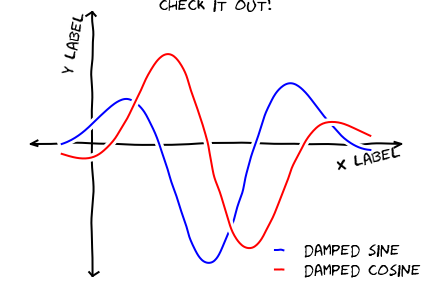

In [19]:
from IPython.display import Image
Image(data=resources['outputs']['output_3_0.png'], format='png')

## Using different preprocessors

To extract the figures when using the HTML exporter, we will want to change which Preprocessors we are using. There are several preprocessors that come with nbconvert, including one called the ExtractOutputPreprocessor.

The ExtractOutputPreprocessor is responsible for crawling the notebook, finding all of the figures, and putting them into the resources directory, as well as choosing the key (i.e. filename_xx_y.extension) that can replace the figure inside the template. To enable the ExtractOutputPreprocessor, we must add it to the exporter’s list of preprocessors:

In [13]:
# create a configuration object that changes the preprocessors
from traitlets.config import Config
c = Config()
c.HTMLExporter.preprocessors = ['nbconvert.preprocessors.ExtractOutputPreprocessor']

# create the new exporter using the custom config
html_exporter_with_figs = HTMLExporter(config=c)
html_exporter_with_figs.preprocessors

['nbconvert.preprocessors.ExtractOutputPreprocessor']

We can compare the result of converting the notebook using the original HTML exporter and our new customized one:

In [14]:
(_, resources)          = html_exporter.from_notebook_node(jake_notebook)
(_, resources_with_fig) = html_exporter_with_figs.from_notebook_node(jake_notebook)

print("resources without figures:")
print(sorted(resources.keys()))

print("\nresources with extracted figures (notice that there's one more field called 'outputs'):")
print(sorted(resources_with_fig.keys()))

print("\nthe actual figures are:")
print(sorted(resources_with_fig['outputs'].keys()))

resources without figures:
['global_content_filter', 'inlining', 'metadata', 'output_extension', 'raw_mimetypes']

resources with extracted figures (notice that there's one more field called 'outputs'):
['global_content_filter', 'inlining', 'metadata', 'output_extension', 'outputs', 'raw_mimetypes']

the actual figures are:
['output_13_1.png', 'output_16_0.png', 'output_18_1.png', 'output_3_0.png', 'output_5_0.png']


## Custom Preprocessors

There are an endless number of transformations that you may want to apply to a notebook. In particularly complicated cases, you may want to actually create your own Preprocessor. Above, when we customized the list of preprocessors accepted by the HTMLExporter, we passed in a string – this can be any valid module name. So, if you create your own preprocessor, you can include it in that same list and it will be used by the exporter.  

To create your own preprocessor, you will need to subclass from nbconvert.preprocessors.Preprocessor and overwrite either the preprocess and/or preprocess_cell methods.  

## Example

The following demonstration adds the ability to exclude a cell by index.  

Note: injecting cells is similar, and won’t be covered here. If you want to inject static content at the beginning/end of a notebook, use a custom template.  

In [15]:
from traitlets import Integer
from nbconvert.preprocessors import Preprocessor

class PelicanSubCell(Preprocessor):
    """A Pelican specific preprocessor to remove some of the cells of a notebook"""

    # I could also read the cells from nb.metadata.pelican if someone wrote a JS extension,
    # but for now I'll stay with configurable value.
    start = Integer(0,  help="first cell of notebook to be converted")
    end   = Integer(-1, help="last cell of notebook to be converted")
    start.tag(config='True')
    end.tag(config='True')

    def preprocess(self, nb, resources):
        self.log.info("I'll keep only cells from %d to %d", self.start, self.end)
        nb.cells = nb.cells[self.start:self.end]
        return nb, resources

Here a Pelican exporter is created that takes PelicanSubCell preprocessors and a config object as parameters. This may seem redundant, but with the configuration system you can register an inactive preprocessor on all of the exporters and activate it from config files or the command line.

In [20]:
# Create a new config object that configures both the new preprocessor, as well as the exporter
c =  Config()
c.PelicanSubCell.start = 4
c.PelicanSubCell.end = 6
c.RSTExporter.preprocessors = [PelicanSubCell]

# Create our new, customized exporter that uses our custom preprocessor
pelican = RSTExporter(config=c)

# Process the notebook
print(pelican.from_notebook_node(jake_notebook)[0])


XKCD plots in Matplotlib

This notebook originally appeared as a blog post at `Pythonic
Perambulations <http://jakevdp.github.com/blog/2012/10/07/xkcd-style-plots-in-matplotlib/>`__
by Jake Vanderplas.

.. raw:: html

   <!-- PELICAN_BEGIN_SUMMARY -->

*Update: the matplotlib pull request has been merged! See* `This
post <http://jakevdp.github.io/blog/2013/07/10/XKCD-plots-in-matplotlib/>`__
*for a description of the XKCD functionality now built-in to
matplotlib!*

One of the problems I’ve had with typical matplotlib figures is that
everything in them is so precise, so perfect. For an example of what I
mean, take a look at this figure:

.. code:: ipython3

    from IPython.display import Image
    Image('http://jakevdp.github.com/figures/xkcd_version.png')




.. image:: output_3_0.png



Sometimes when showing schematic plots, this is the type of figure I
want to display. But drawing it by hand is a pain: I’d rather just use
matplotlib. The problem is, matplotlib is a bit too precise